In [16]:
from time import time
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.datasets import fetch_lfw_people
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA, FastICA
from sklearn.svm import SVC
from sklearn.utils.fixes import loguniform

## Reading the LFW People Dataset

In [17]:
lfw_people = fetch_lfw_people(min_faces_per_person=100, resize=0.4)

# introspect the images arrays to find the shapes (for plotting)
n_samples, h, w = lfw_people.images.shape

# for machine learning we use the 2 data directly (as relative pixel
# positions info is ignored by this model)
X = lfw_people.data
n_features = X.shape[1]

# the label to predict is the id of the person
y = lfw_people.target
target_names = lfw_people.target_names
n_classes = target_names.shape[0]

print("Total dataset size:")
print("n_samples: %d" % n_samples)
print("n_features: %d" % n_features)
print("n_classes: %d" % n_classes)

Total dataset size:
n_samples: 1140
n_features: 1850
n_classes: 5


## Splitting the dataset to train and test

In [18]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## Using PCA to extarct Eigen faces

In [19]:
n_components = 300

print(
    "Extracting the top %d eigenfaces from %d faces" % (n_components, X_train.shape[0])
)
t0 = time()
pca = PCA(n_components=n_components, svd_solver="randomized", whiten=True).fit(X_train)
print("done in %0.3fs" % (time() - t0))

eigenfaces = pca.components_.reshape((n_components, h, w))

print("Projecting the input data on the eigenfaces orthonormal basis")
t0 = time()
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)
print("done in %0.3fs" % (time() - t0))

Extracting the top 300 eigenfaces from 912 faces
done in 0.092s
Projecting the input data on the eigenfaces orthonormal basis
done in 0.016s


## Fitting the SVM classifier algorithm

In [20]:
print("Fitting the classifier to the training set")
t0 = time()
param_grid = {
    "C": loguniform(1e3, 1e5),
    "gamma": loguniform(1e-4, 1e-1),
}
clf = RandomizedSearchCV(
    SVC(kernel="rbf", class_weight="balanced"), param_grid, n_iter=10
)
clf = clf.fit(X_train_pca, y_train)
print("done in %0.3fs" % (time() - t0))
print("Best estimator found by grid search:")
print(clf.best_estimator_)

Fitting the classifier to the training set
done in 5.910s
Best estimator found by grid search:
SVC(C=52154.207443355415, class_weight='balanced', gamma=0.0004725955076485727)


## Classification using SVM

In [21]:
print("Predicting people's names on the test set")
t0 = time()
y_pred = clf.predict(X_test_pca)
print("done in %0.3fs" % (time() - t0))

print(classification_report(y_test, y_pred, target_names=target_names))
ConfusionMatrixDisplay.from_estimator(clf, X_test_pca, y_test,display_labels=target_names, xticks_rotation="vertical")
plt.tight_layout()
plt.show()

Predicting people's names on the test set
done in 0.032s
                   precision    recall  f1-score   support

     Colin Powell       0.84      0.94      0.89        50
  Donald Rumsfeld       0.83      0.96      0.89        25
    George W Bush       0.93      0.87      0.90       106
Gerhard Schroeder       0.90      0.86      0.88        22
       Tony Blair       0.87      0.80      0.83        25

         accuracy                           0.89       228
        macro avg       0.87      0.89      0.88       228
     weighted avg       0.89      0.89      0.89       228



AttributeError: type object 'ConfusionMatrixDisplay' has no attribute 'from_estimator'

In [22]:
score = clf.score(X_test_pca, y_test)
print(f"n_components={n_components}, test accuracy={score:.2f}")

n_components=300, test accuracy=0.89


## Plotting the images for which the eigen faces have been extracted and classified

In [23]:
def plot_gallery(images, titles, h, w, n_row=5, n_col=5):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=0.01, right=0.99, top=0.90, hspace=0.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())

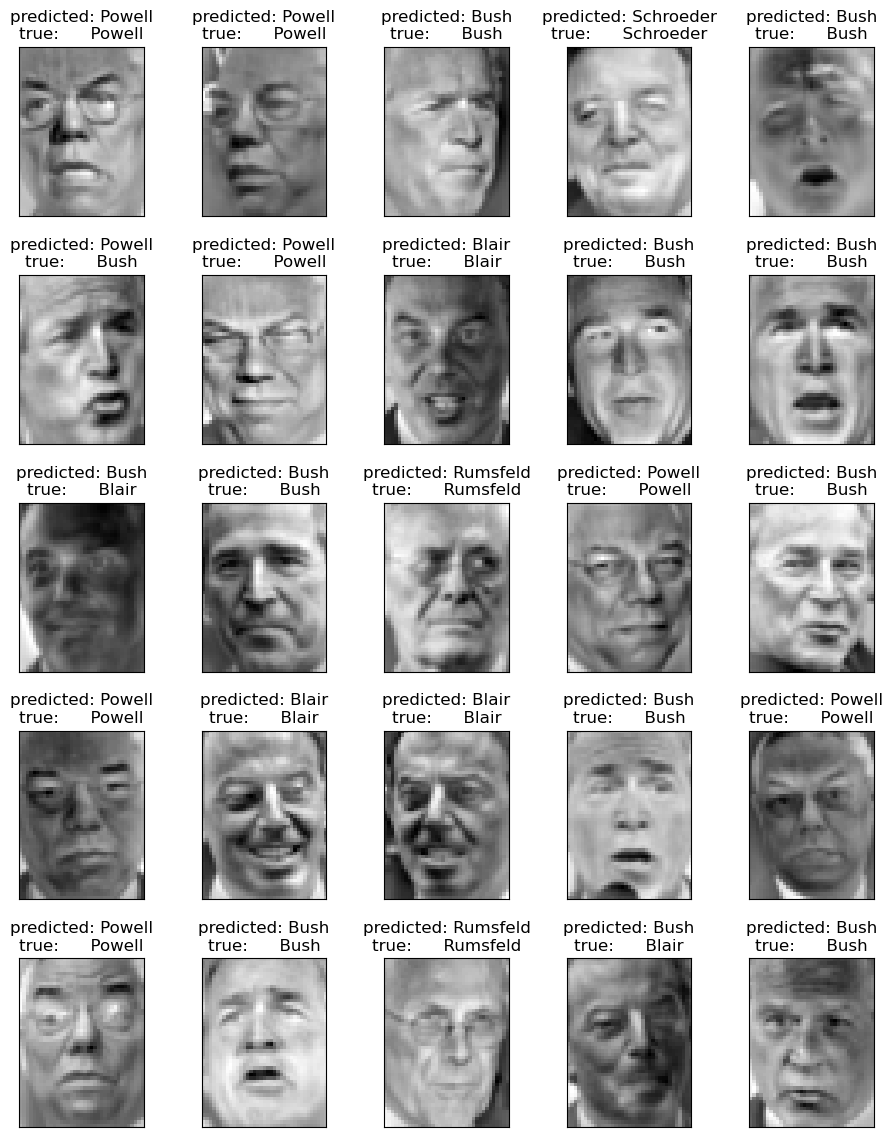

In [24]:
def title(y_pred, y_test, target_names, i):
    pred_name = target_names[y_pred[i]].rsplit(" ", 1)[-1]
    true_name = target_names[y_test[i]].rsplit(" ", 1)[-1]
    return "predicted: %s\ntrue:      %s" % (pred_name, true_name)


prediction_titles = [
    title(y_pred, y_test, target_names, i) for i in range(y_pred.shape[0])
]

plot_gallery(X_test, prediction_titles, h, w)

Plotting the Eigen Faces

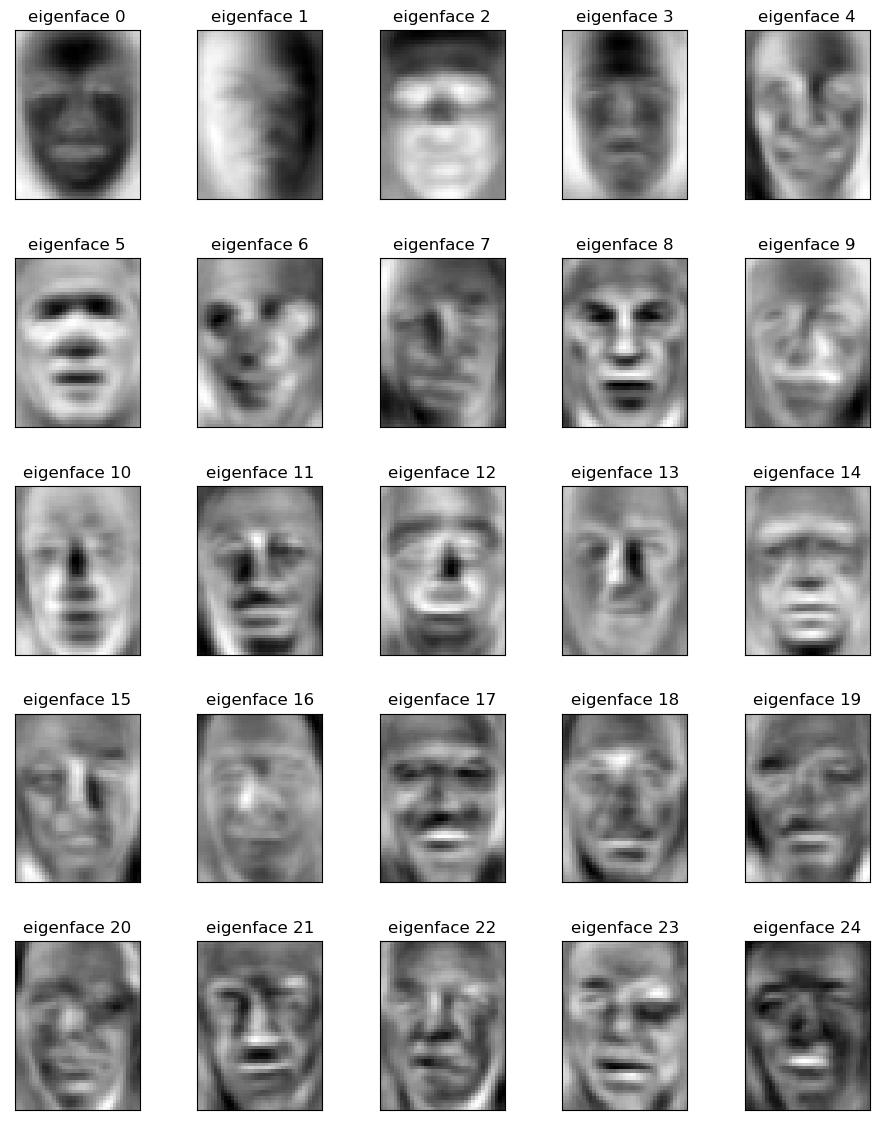

In [25]:
eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces.shape[0])]
plot_gallery(eigenfaces, eigenface_titles, h, w)

plt.show()

## Different Parameters for PCA

In [30]:
for n_components in [10, 25, 50, 75, 100, 150, 200]:
    # Apply PCA to the training data
    pca = PCA(n_components=n_components)
    X_train_pca = pca.fit_transform(X_train)

    # Train the SVM classifier on the training data
    clf.fit(X_train_pca, y_train)

    # Apply PCA to the testing data and evaluate the classifier
    X_test_pca = pca.transform(X_test)
    score = clf.score(X_test_pca, y_test)
    print(f"n_components={n_components}, test accuracy={score:.2f}")

n_components=10, test accuracy=0.59
n_components=25, test accuracy=0.79
n_components=50, test accuracy=0.84
n_components=75, test accuracy=0.89
n_components=100, test accuracy=0.89
n_components=150, test accuracy=0.89
n_components=200, test accuracy=0.88


## Using ICA to extract Eigen Faces

In [ ]:
n_components = 300

print("Extracting the top %d eigenfaces from %d faces" % (n_components, X_train.shape[0]))
t0 = time()
ica = FastICA(n_components=n_components, whiten="arbitrary-variance").fit(X_train)
print("done in %0.3fs" % (time() - t0))

eigenfaces = ica.components_.reshape((n_components, h, w))

print("Projecting the input data on the eigenfaces orthonormal basis")
t0 = time()
X_train_pca = ica.transform(X_train)
X_test_pca = ica.transform(X_test)
print("done in %0.3fs" % (time() - t0))

In [ ]:
print("Fitting the classifier to the training set")
t0 = time()
param_grid = {
    "C": loguniform(1e3, 1e5),
    "gamma": loguniform(1e-4, 1e-1),
}
clf = RandomizedSearchCV(
    SVC(kernel="rbf", class_weight="balanced"), param_grid, n_iter=10
)
clf = clf.fit(X_train_pca, y_train)
print("done in %0.3fs" % (time() - t0))
print("Best estimator found by grid search:")
print(clf.best_estimator_)

In [ ]:
print("Predicting people's names on the test set")
t0 = time()
y_pred = clf.predict(X_test_pca)
print("done in %0.3fs" % (time() - t0))

print(classification_report(y_test, y_pred, target_names=target_names))
ConfusionMatrixDisplay.from_estimator(
    clf, X_test_pca, y_test, display_labels=target_names, xticks_rotation="vertical"
)
plt.tight_layout()
plt.show()

In [ ]:
score = clf.score(X_test_pca, y_test)
print(f"n_components={n_components}, test accuracy={score:.2f}")

In [ ]:
def plot_gallery(images, titles, h, w, n_row=5, n_col=5):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=0.01, right=0.99, top=0.90, hspace=0.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())

In [ ]:
def title(y_pred, y_test, target_names, i):
    pred_name = target_names[y_pred[i]].rsplit(" ", 1)[-1]
    true_name = target_names[y_test[i]].rsplit(" ", 1)[-1]
    return "predicted: %s\ntrue:      %s" % (pred_name, true_name)


prediction_titles = [
    title(y_pred, y_test, target_names, i) for i in range(y_pred.shape[0])
]

plot_gallery(X_test, prediction_titles, h, w)

In [ ]:
eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces.shape[0])]
plot_gallery(eigenfaces, eigenface_titles, h, w)

plt.show()

## Different Parametes for ICA

In [ ]:
for n_components in [10, 25, 50, 75, 100, 150, 200]:
    # Apply ICA to the training data
    ica = FastICA(n_components=n_components, random_state=42, whiten="arbitrary-variance")
    X_train_ica = ica.fit_transform(X_train)

    # Train the SVM classifier on the training data
    clf.fit(X_train_ica, y_train)

    # Apply ICA to the testing data and evaluate the classifier
    X_test_ica = ica.transform(X_test)
    score = clf.score(X_test_ica, y_test)
    print(f"n_components={n_components}, test accuracy={score:.2f}")